In [64]:

import csv
import math
import scipy.linalg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy.linalg import inv

In [84]:
# Read output-energy file as fixed-width file (fwf) into dataframe object, columns aren't labeled with a header
energyDF = pd.read_csv('xfit.dat', header=None, delim_whitespace=True).to_numpy()

# extract the SPEs and TBME's for the background (n50em) interaction
backgroundHam = energyDF[0,6:75]      # First 5 terms are not Hamiltonian parameters and can be dropped

# do the same for the fitted interaction from BAB
fittedHam = energyDF[1,6:75]

# extract experimental energies and experimental errors from dataframe
exp = energyDF[2:,2]
error = energyDF[2:,3]

# Construct a matrix containing the energy contributions from each Hamiltonian parameter to each nuclear state
E = np.empty([len(exp),len(backgroundHam)])
for i in range(len(backgroundHam)):
    E[:,i] = energyDF[2:,i+6]*backgroundHam[i]
#print(E)
print(energyDF[2:,4])
print(scipy.linalg.norm(energyDF[2:,4]-exp)/math.sqrt(len(exp)))

[   0.      -14.8643  -14.239   -13.3503  -31.2163  -29.7635  -29.2777
  -28.5505  -44.5765  -44.1255  -43.8173  -43.2157  -42.6568  -59.5748
  -58.0812  -57.4038  -57.3462  -57.1442  -57.0594  -56.8225  -56.772
  -71.1596  -71.028   -70.3988  -70.021   -69.6565  -69.2951  -84.7173
  -83.0275  -82.4888  -82.1651  -82.8864  -82.1982  -94.7406  -94.4752
  -93.8422  -93.6836  -93.2555  -93.2595  -93.1391  -93.0097  -92.9323
  -92.7074  -92.6804  -90.7826 -106.6541 -105.1128 -104.3866 -104.2335
 -103.5876 -103.4708 -102.8346 -102.2633 -115.3245 -114.9816 -114.466
 -113.8821 -114.0378 -113.8553 -113.801  -113.5091 -112.2567 -112.2898
 -111.6458 -111.1663 -125.9588 -124.1223 -123.2542 -122.7592 -122.8312
 -122.4169 -122.5362 -122.4197 -122.1019 -121.9248 -133.1196 -132.1537
 -131.6244 -131.5636 -131.0029 -130.4938 -130.5223 -130.5054 -130.2071
 -129.8598 -128.9543 -128.6564 -128.2403 -141.3565 -139.5335 -139.1172
 -139.0695 -138.6523 -138.7134 -138.2632 -138.0361 -137.9016 -137.863
 -136.224

In [66]:
# Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
pInit = np.empty(len(backgroundHam))
pInit.fill(1)                         # Initial Hamiltonian parameter weights are all 1 (unfitted)
e = np.empty(len(backgroundHam))
G = np.empty((len(backgroundHam),len(backgroundHam)))
for i in range(len(backgroundHam)):           # Contructing data vector (e)
    eTot = 0
    for k in range(len(exp)):
        eTot += (exp[k]*E[k,i])/(error[k]**2)
    e[i] = eTot
for i in range(len(backgroundHam)):           # Constructing design matrix (G)
    for j in range(len(backgroundHam)):
        gTot = 0
        for k in range(len(exp)):
            gTot += (E[k,i]*E[k,j])/(error[k]**2)
        G[i,j] = gTot

In [67]:
# Here we perform an SVD of our design matrix and invert the singular values (in S)
# to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
U, Svec, Ut = np.linalg.svd(G)
# Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
# e and p into new vectors c and y, respectively
c = np.dot(Ut,e)
y = np.dot(Ut,pInit)

35 vlc eRMS = 0.10725068611293052  pRMS =  0.28028126606947323
full SVD eRMS = 0.0730424677649219  pRMS = 0.7594358426985944


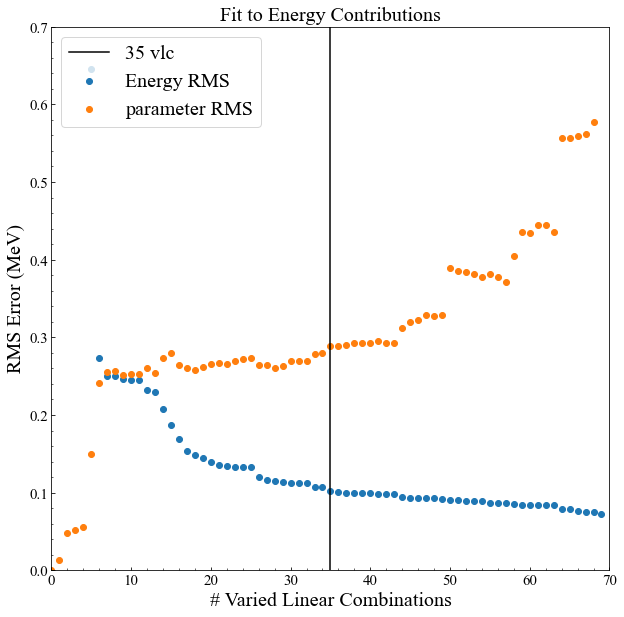

In [68]:
# This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
# at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
eRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
pRMS = np.empty(len(Svec)+1)
for i in range(len(backgroundHam)+1):
    yfit = np.zeros(len(backgroundHam))
    fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
    fitEnergies = np.empty(len(exp))                    # Array for storing fitted energies in this iteration
    for j in range(len(backgroundHam)):
        if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
            yfit[j] = c[j]/Svec[j]
        elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
            yfit[j] = y[j]
    pfit = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
    for j in range(len(backgroundHam)):       
        fitParameters[j] = pfit[j]*backgroundHam[j] # Modify our initial fit parameters by the new weights in pfit
    for j in range(len(exp)):
        eFitTot = 0
        for k in range(len(backgroundHam)):
            eFitTot += pfit[k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
        fitEnergies[j] = eFitTot
    eResidual = exp - fitEnergies
    pResidual = backgroundHam - fitParameters
    eRMS[i] = scipy.linalg.norm(eResidual)/math.sqrt(len(eResidual))
    pRMS[i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
print('35 vlc eRMS =', eRMS[34], ' pRMS = ', pRMS[34])
print('full SVD eRMS =', eRMS[69], ' pRMS =', pRMS[69])
x = [i for i in range(len(eRMS))]
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.scatter(x, eRMS, label='Energy RMS')
plt.scatter(x, pRMS, label='parameter RMS')
plt.axvline(x = 35, color = 'k', label = '35 vlc')
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
plt.title('Fit to Energy Contributions',fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in")
plt.legend(loc=2,fontsize=20)
plt.show()

In [69]:
Ginv = inv(G)
pfinal = np.dot(Ginv,e)
newHam = np.empty(len(backgroundHam))
for i in range(len(newHam)):
    newHam[i] = pfinal[i]*backgroundHam[i]
pRes = newHam-backgroundHam

for j in range(len(exp)):
        eFitTot = 0
        for k in range(len(backgroundHam)):
            eFitTot += pfit[k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
        fitEnergies[j] = eFitTot
eRes = fitEnergies - exp
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))
print('least squares parameter RMS =', scipy.linalg.norm(pRes)/math.sqrt(len(pRes)))
print(newHam-fittedHam)              # Difference between BAB Hamiltonian and my least squares


least squares energy RMS = 0.0730424677649219
least squares parameter RMS = 0.7594358514441637
[-0.07039     0.08002688  0.07055904  0.02639117  0.86677542  0.0673503
  0.04428293  1.86010425  0.01877567 -0.23573182 -0.37040785  0.09833528
 -0.12539     0.83665821  0.0094135  -0.51390106 -0.28396517  0.16709511
 -0.25632821  0.23108024  0.22822028 -0.21501158  1.42597054  0.24155135
  0.33184811  0.10608999 -0.06226312  0.00905033 -0.01592862  0.08285926
  0.07137186 -0.1717767  -0.44334941 -0.05443403 -0.10308286 -0.26256482
  0.05218373  0.19389946  0.15008847 -0.20460977  0.06224645  0.0410493
 -0.15991575  0.15563875  0.09135578  0.11867264 -0.01074267  0.98638555
  0.08646971 -0.3244903  -0.06886304 -0.1644319   0.10017356 -0.05331987
 -0.06355995  0.02026417  0.14644342 -0.29094909 -0.17394835 -0.13170761
  0.00707308  0.00833793 -0.01977819 -0.15725782 -0.04132307 -0.01120781
  0.00600247  0.21271716 -0.00750142]


In [88]:
outputs1 = np.array([exp, error, energyDF[2:,4], fitEnergies, energyDF[2:,4]-fitEnergies])
outputs2 = np.array([fittedHam, newHam, newHam-fittedHam])

with open("outputs.dat","w") as f:
    f.write("exp    error     BAB     JP     Diff \n")
    np.savetxt(f, outputs1.T, delimiter=' ', fmt='%10.4f')
    f.write("BAB    JP    Diff \n")
    np.savetxt(f, outputs2.T, delimiter=' ', fmt='%10.4f')
    f.write("\n")
    f.write("Elements of G: \n")
    np.savetxt(f, G, delimiter=' ', fmt='%15.4f')

In [82]:
# Least squares solution using numpy linalg as a check that my least squares solution agrees
newExp = exp*10
M = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    for j in range(len(backgroundHam)):
        M[i,j] = E[i,j]*10
lstSq = np.linalg.lstsq(M, newExp, rcond=None)

#print(lstSq[0])                    # This is the set of weights which minimizes least squares for the energy contributions
lsEnergy = np.empty(len(exp))
for j in range(len(exp)):
        eFitTot = 0
        for k in range(len(backgroundHam)):
            eFitTot += lstSq[0][k]*E[j,k]                # Modify our initial energy contributions to state j by new weights
        lsEnergy[j] = eFitTot
eRes = lsEnergy - exp
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))

lsHam = np.empty(len(backgroundHam))
for i in range(len(lsHam)):
    lsHam[i] = lstSq[0][i]*backgroundHam[i]
print(lsHam-fittedHam)                                  # Difference between BAB Hamiltonian and my least squares

least squares energy RMS = 0.0730424677649269
[-0.07038999  0.08002687  0.07055905  0.02639117  0.86677543  0.06735029
  0.04428293  1.86010426  0.01877568 -0.23573184 -0.37040784  0.09833529
 -0.12539001  0.83665822  0.00941351 -0.51390105 -0.28396518  0.16709512
 -0.25632822  0.23108026  0.22822029 -0.2150116   1.42597059  0.24155134
  0.33184812  0.10608998 -0.06226311  0.00905033 -0.01592862  0.08285926
  0.07137186 -0.17177671 -0.44334942 -0.05443403 -0.10308285 -0.26256482
  0.05218373  0.19389946  0.15008847 -0.20460977  0.06224645  0.0410493
 -0.15991575  0.15563874  0.09135578  0.11867264 -0.01074267  0.98638555
  0.08646971 -0.32449029 -0.06886304 -0.1644319   0.10017356 -0.05331987
 -0.06355995  0.02026417  0.14644342 -0.29094909 -0.17394835 -0.13170761
  0.00707308  0.00833793 -0.01977819 -0.15725782 -0.04132307 -0.01120781
  0.00600247  0.21271716 -0.00750142]
